Run the cell below if you are using Google Colab to mount your Google Drive in your Colab instance. Adjust the path to the files in your Google Drive as needed if it differs.

If you do not use Google Colab, running the cell will simply do nothing, so do not worry about it.

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd 'drive/My Drive/Colab Notebooks/09_Graph_Mining'
except ImportError as e:
    pass

## Graph mining

Graph mining uses the graph structure to solve different tasks in the area of machine learning e.g.
- [Representation learning for nodes and edges](https://stellargraph.readthedocs.io/en/stable/demos/embeddings/index.html)
  - create a fixed sized vector for each node/edge
  - used as input for downstream ML tasks or visualization etc
- [**Classification of nodes**](https://stellargraph.readthedocs.io/en/stable/demos/node-classification/index.html) or edges
  - to which class does a particular node/edge belongs?
- [Classification of whole graphs](https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/index.html)
  - to which class does a graph belong?
  - interesting in the medical domain (each graph represents a chemical compound)
- [Link prediction](https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/index.html)
  - given a graph, answer the question if an edge between two nodes should exist (binary classification)
  - or what type of edge it should have
  - also called knowledge base completion

We will focus on **node classification** for this exercise

### Library to use

- We will use [Stellar Graph](https://www.stellargraph.io) library
  - open source ([link to github](https://github.com/stellargraph/stellargraph))
- Installation as usual with `pip install stellargraph[demos]`
  - currently not available for Python 3.9
    - use [anaconda virtual environment](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) with python 3.8
    - `conda create --name myenv anaconda python=3.8`
    - let us know if we should help you
- [Comprehensive documentation](https://stellargraph.readthedocs.io) available

In [2]:
#%pip install stellargraph[demos]

### Classification of Nodes with Graph Convolutional Network (GCN)
- in this example we will use the CORA dataset
  - consists of 2708 scientific publications about machine learning (nodes)
  - edges are citations of these publications (5429 links) - thus also called citation network
    - edges are directed but treated as undirected in this exercise
  - the task is to do node classification into into one of seven classes
    - Case_Based, Genetic_Algorithms, Neural_Networks, Probabilistic_Methods
    - Reinforcement_Learning, Rule_Learning, Theory
  - the nodes (publication) already have a vector representation
    - word vector indicating whether each word in the vocabulary is present (1) or not (0)
    - vocabulary size is 1433
- the following introduction is based on the [demo of stellar graph](https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html)

### Data loading
- the data can directly be loaded from dataset loaders in Stellar Graph
  - later we also see how to load this data from file

In [3]:
import stellargraph as sg

dataset = sg.datasets.Cora()
G, node_subjects = dataset.load()

print(G.info())
print("\n\nnode subjects:")
print(node_subjects)

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


node subjects:
31336             Neural_Networks
1061127             Rule_Learning
1106406    Reinforcement_Learning
13195      Reinforcement_Learning
37879       Probabilistic_Methods
                    ...          
1128975        Genetic_Algorithms
1128977        Genetic_Algorithms
1128978        Genetic_Algorithms
117328                 Case_Based
24043             Neural_Networks
Name: subject, Length: 2708, dtype: object


### Analyze the Target Variable

In [4]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


### Split into Training, Validation, and Test
- `node_subjects` is a pandas `Series`
  - the index of it corresponds to the node id
  - the value corresponds to the target
  - thus we only need to split the `node_subjects`

In [5]:
from sklearn.model_selection import train_test_split 

node_ids = node_subjects.index
targets = node_subjects.values

node_ids_train, node_ids_test, target_train, target_test = train_test_split(
    node_ids, targets, train_size=140, stratify=targets, random_state=1278
)
node_ids_val, node_ids_test, target_val, target_test = train_test_split(
    node_ids_test, target_test, train_size=500, stratify=target_test, random_state=1278
)
print(f"train: {len(target_train)} validation: {len(target_val)} test: {len(target_test)}")

train: 140 validation: 500 test: 2068


### Encode the target variable
- **one-hot representation** of the target variable is compared to the model’s **soft-max output**

In [6]:
from sklearn.preprocessing import LabelBinarizer

target_encoding = LabelBinarizer()

enc_target_train = target_encoding.fit_transform(target_train) # here calling fit_transform to create the mapping
enc_target_val = target_encoding.transform(target_val) # here only transform to apply the mapping
enc_target_test = target_encoding.transform(target_test)

enc_target_train[:10]

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]])

### Creating Tranformation from Graph to Vector

The machine learning model in StellarGraph consists of:
- the graph layers such as graph convolution, dense layers etc
- a **data generator** to convert the graph structure (including node features) into vectors fed into the network

In this example we will use [`FullBatchNodeGenerator`](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.FullBatchNodeGenerator) as the data generator (many more exists for different tasks)
- `method='gcn'` is specified to yield data for GCN
  - capture the graph structure with the [normalized graph Laplacian matrix](https://en.wikipedia.org/wiki/Laplacian_matrix#Symmetric_normalized_Laplacian)
- call the [`flow`](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.FullBatchNodeGenerator.flow) function to actually do the transformation
  - this function expects as the first parameter the `node_ids`
  - second parameter: `targets`

In [7]:
from stellargraph.mapper import FullBatchNodeGenerator
generator = FullBatchNodeGenerator(G, method="gcn") # create the generator

# call the flow function to create the input for the network
# needs node ids and targets (in this example one hot encoded)
train_gen = generator.flow(node_ids_train, enc_target_train)

Using GCN (local pooling) filters...


### Creating the GCN layers and model
- StellarGraph uses Keras (Tensorflow) instead of PyTorch
  - but the idea is still the same
- using the [`GCN`](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GCN) layer to do the actual [graph convolution](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GraphConvolution)
  - parameters:
     - `layer_sizes`: the number of hidden GCN layers and their sizes
     - `activations`: the activation to apply to each GCN layer’s output
     - `dropout`: the rate of dropout for the input of each GCN layer

In [8]:
from stellargraph.layer import GCN
from tensorflow.keras import layers, optimizers, losses, metrics, Model

gcn = GCN(layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5)
x_inp, x_out = gcn.in_out_tensors()

# creating a dense layer to map to the correct number of classes
# because the output of the GCN layer is a 16-dimensional vector (we only have 7 target classes)
predictions = layers.Dense(units=enc_target_train.shape[1], activation="softmax")(x_out) 

model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

C:\tools\Anaconda3\envs\dm1\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Train the Model
- generate a validation data to measure overfitting
  - use it for early stopping
- fit the model

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

val_gen = generator.flow(node_ids_val, enc_target_val)
es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 [==============================] - 5s 5s/step - loss: 1.9541 - acc: 0.0786 - val_loss: 1.9209 - val_acc: 0.3580
Epoch 2/200
1/1 [==============================] - 0s 393ms/step - loss: 1.9147 - acc: 0.3571 - val_loss: 1.8915 - val_acc: 0.3960
Epoch 3/200
1/1 [==============================] - 0s 385ms/step - loss: 1.8680 - acc: 0.4000 - val_loss: 1.8478 - val_acc: 0.3920
Epoch 4/200
1/1 [==============================] - 0s 383ms/step - loss: 1.8097 - acc: 0.3714 - val_loss: 1.7917 - val_acc: 0.3540
Epoch 5/200
1/1 [==============================] - 0s 384ms/step - loss: 1.7327 - acc: 0.3643 - val_loss: 1.7296 - val_acc: 0.3520
Epoch 6/200
1/1 [==============================] - 0s 448ms/step - loss: 1.6518 - acc: 0.3500 - val_loss: 1.6680 - val_acc: 0.3460
Epoch 7/200
1/1 [==============================] - 0s 499ms/step - loss: 1.5623 - acc: 0.3786 - val_loss: 1.6049 - val_acc: 0.3660
Epoch 8/200
1/1 [==============================] - 1s 568ms/step - loss: 1.4887 - acc:

### Analyze the training progress
- StellarGraph has a nice function to plot the train and validation accuracy/loss

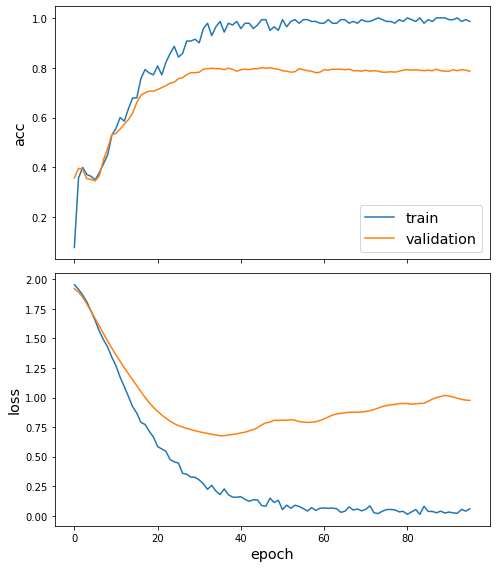

In [10]:
sg.utils.plot_history(history)

### Test the Model
- as usual we test our model on the test data to see how well it will perform

In [11]:
test_gen = generator.flow(node_ids_test, enc_target_test)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 146ms/step - loss: 0.7720 - acc: 0.7998

Test Set Metrics:
	loss: 0.7720
	acc: 0.7998


### Making predictions
- now let's have a look on how to create predictions when we do not have any ground truth
  - in this example we predict the labels for all nodes in the graph

In [12]:
import numpy as np
np.set_printoptions(linewidth=100, suppress=True) # don't use scientific notation

# no target variable because we want to only predict
all_gen = generator.flow(node_ids) 

# all_predictions is the one hot encoded vector of our classes
all_predictions = model.predict(all_gen)
print(all_predictions.squeeze()[:10])

# let use the target_encoding to get the actual label back
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())
print(node_predictions[:10])

[[0.00000013 0.0000003  0.9998677  0.00002669 0.00000001 0.00001393 0.00009133]
 [0.02106215 0.02056529 0.0398931  0.03200551 0.0022184  0.77669364 0.1075619 ]
 [0.00103685 0.00007324 0.00002397 0.00011145 0.9962962  0.0000213  0.00243703]
 [0.00344947 0.00409031 0.00106709 0.01526868 0.9371091  0.00033466 0.03868066]
 [0.         0.00000009 0.00000009 0.99959534 0.00000001 0.00000051 0.00040396]
 [0.00003637 0.00222341 0.00058804 0.9088123  0.00447885 0.001105   0.08275613]
 [0.00129806 0.00271295 0.00775883 0.17215094 0.15815866 0.00390847 0.6540121 ]
 [0.00007543 0.00031793 0.9980426  0.00024782 0.00000602 0.00013369 0.00117658]
 [0.00000021 0.0000004  0.9998379  0.00003018 0.00000001 0.00001979 0.00011146]
 [0.00047295 0.00501547 0.1060646  0.05757733 0.0640369  0.0024659  0.7643668 ]]
['Neural_Networks' 'Rule_Learning' 'Reinforcement_Learning' 'Reinforcement_Learning'
 'Probabilistic_Methods' 'Probabilistic_Methods' 'Theory' 'Neural_Networks' 'Neural_Networks'
 'Theory']


### Retrieve the Node Embeddings
- if we want to get the fixed vector representation of each node, we need to change the model
  - previously we added a dense layer on top to map to our classes which is not neccessary any more
  - we just want to get the output of the `GCN` layer
  - therefore we redefine our model

In [13]:
# output is now the output of the GCN layer
embedding_model = Model(inputs=x_inp, outputs=x_out)
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2708, 16)

### Plot the Embedding in 2D Space
- in this example the embedding has 16 dimension which is hard for a human to look at
  - the dimensionality is reduced to two
  - common algorithms (implemented in scikit learn):
    - [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
    - [t-distributed Stochastic Neighbor Embedding (t-SNE or TSNE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [14]:
#from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X = emb.squeeze(0) # remove the first dimension which represents the batch (1, 2708, 16) -> (2708, 16)

trans = TSNE(n_components=2) # TSNE can be replaced by PCA 
X_reduced = trans.fit_transform(X)
X_reduced.shape

C:\tools\Anaconda3\envs\dm1\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\tools\Anaconda3\envs\dm1\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(2708, 2)

In [15]:
node_subjects.astype("category").cat.codes

31336      2
1061127    5
1106406    4
13195      4
37879      3
          ..
1128975    1
1128977    1
1128978    1
117328     0
24043      2
Length: 2708, dtype: int8

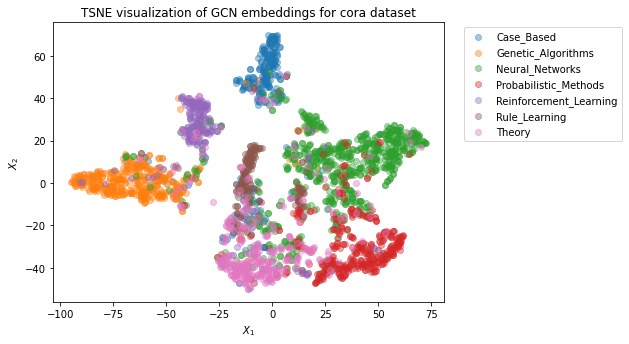

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7))

for target_value in np.unique(targets):
    rows_of_target_value = np.where(targets==target_value)
    ax.scatter(
        X_reduced[rows_of_target_value, 0],
        X_reduced[rows_of_target_value, 1],
        alpha=0.4,
        label=target_value
    )

ax.legend(bbox_to_anchor=(1.04,1));
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"TSNE visualization of GCN embeddings for cora dataset",
);

## Node2Vec
- now we use for the same task **Node2Vec**
- basic idea behind is to 
 1. generate random walks in the graph
 1. train a word2vec model on it


- StellarGraph has implementations for random walks e.g. [`BiasedRandomWalk`](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.data.BiasedRandomWalk)
- parameters:
  - `length`: maximum length of a random walk
  - `n`: number of random walks per root node
  - `p`: Defines (unormalised) probability, 1/p, of returning to source node
  - `q`: Defines (unormalised) probability, 1/q, for moving away from source node

In [17]:
from stellargraph.data import BiasedRandomWalk
rw = BiasedRandomWalk(G)

# can take some time...
walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100, n=10, p=0.5, q=2.0,
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 27080


### Compute Node Embedding via Word2Vec
- in this example we use the implementation of word2vec from gensim library
- parameters for the [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) model:
  - `vector_size`: Dimensionality of the vectors
  - `window`: Maximum distance between the current and predicted word within a walk
  - `min_count`: Ignores all words with total frequency lower than this (should be set to 0 to include all nodes)
  - `sg`: Training algorithm: 1 for skip-gram; otherwise CBOW
  - `workers`: Use these many worker threads to train the model
  - `epochs`: Number of iterations (epochs) over the corpus

In [18]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks] # need to convert node ids to string

# usually training longer than 1 epoch is necessary to learn a good model
# parameter names in older gensim: vector_size -> size, epochs -> iter
model = Word2Vec(str_walks, vector_size=128, window=5, min_count=0, sg=1, workers=2, epochs=1)

### Get the Embedding
- embedding vectors can be retrieved from `model.wv` using the node ID as key

In [19]:
model.wv["19231"]

array([ 0.06336308, -0.22181042, -0.0774212 ,  0.03256027,  0.3141983 ,  0.21183154, -0.08185443,
        0.9395966 ,  0.25366303, -0.293692  ,  0.16298757, -0.4613215 , -0.3670247 , -0.6562351 ,
       -0.15666883, -0.04041138, -0.14766955, -0.40861455,  0.11909629,  0.4460831 , -0.32373327,
       -0.3562607 ,  0.30711073, -0.06855016, -0.785978  , -0.17470893, -0.1624135 ,  0.4295342 ,
       -0.5760073 ,  0.00954579,  0.0891932 , -0.08751246, -0.39355874, -0.23344132, -0.7308601 ,
       -0.4984202 ,  0.84725386,  0.16652182, -0.04170012, -0.02751265,  0.64892584, -0.44645792,
        0.4006236 , -0.19428335, -0.3586973 , -0.78067136,  0.5242733 , -0.62109184, -0.28818312,
        0.2713004 ,  0.23574336, -0.91070366, -0.17962228, -0.6705935 ,  0.12543036, -0.52535963,
        0.3332295 ,  0.33311638, -0.10493669,  0.39280707, -0.43156907,  0.539816  ,  0.04177816,
        0.30559903, -0.15191261, -0.10277524,  0.34702873, -0.33296168,  0.07409106, -0.18265311,
       -0.43434298, 

## Visualise Node Embeddings
- this can be done similarly as for GCN

In [20]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs, index2word in older gensim versions
node_embeddings = (model.wv.vectors)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects[[int(node_id) for node_id in node_ids]]

# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

C:\tools\Anaconda3\envs\dm1\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\tools\Anaconda3\envs\dm1\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


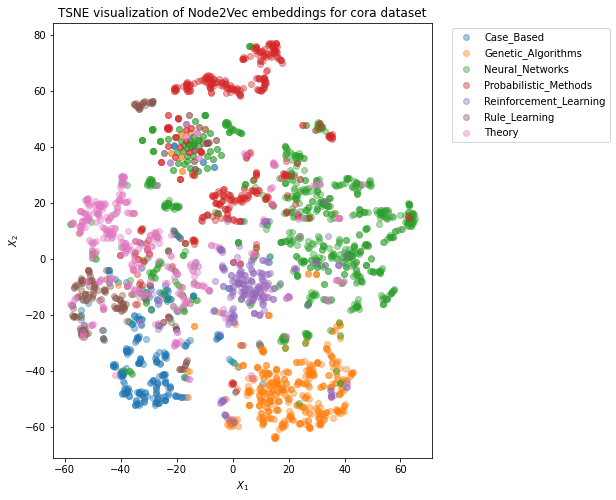

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))

for target_value in np.unique(node_targets):
    rows_of_target_value = np.where(node_targets==target_value)
    ax.scatter(
        node_embeddings_2d[rows_of_target_value, 0],
        node_embeddings_2d[rows_of_target_value, 1],
        alpha=0.4,
        label=target_value
    )

ax.legend(bbox_to_anchor=(1.04,1));
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"TSNE visualization of Node2Vec embeddings for cora dataset",
);

## Use Embeddings for Node Classification
- split the data
- apply usual classification

In [22]:
X = node_embeddings
y = np.array(node_targets)
#train_size=140, stratify=targets, random_state=1278
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.1, random_state=1278)
print(f"train: {len(X_train)} test: {len(X_test)}")

train: 270 test: 2438


In [23]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=False)

In [24]:
y_pred = clf.predict(X_test)

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7223133716160788

Due to the fact that we have not the same split as for GCN we cannot compare the accuracy score (this is done in the exercise).

## Data loading from file

- in case you want to apply these algorithms to your own files, you need to load the data usually from file

- to load a simple `StellarGraph` 
  - you just need a pandas `Dataframe` with columns `source` and `target` representing the edges
  - you can also specify the column names for source and target with `source_column="first", target_column="second"`

In [26]:
import pandas as pd
from stellargraph import StellarGraph

simple_edges = pd.DataFrame(
    {"source": ["a", "b", "c", "d", "a"], "target": ["b", "c", "d", "a", "c"]}
)
display(simple_edges)

graph = StellarGraph(edges=simple_edges)
print(graph.info())

,source,target
0,a,b
1,b,c
2,c,d
3,d,a
4,a,c


StellarGraph: Undirected multigraph
 Nodes: 4, Edges: 5

 Node types:
  default: [4]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [5]
        Weights: all 1 (default)
        Features: none


## Adding Data to the Edges
- in case the edges have further information, they are added as additional columns 
  - **special case**: if you want to use edge weights/confidences then the column name needs to be **`weight`**
  - all other columns are treated as additional **edge features**

In [27]:
enhanced_edges = pd.DataFrame(
    {
        "source": ["a", "b", "c", "d", "a"],
        "target": ["b", "c", "d", "a", "c"],
        "weight": [1.0, 0.2, 3.4, 5.67, 1.0],
        "A": [0.4, 0.1, 0.9, 0, 0.9],
        "B": [12, 34, 56, 78, 90],
    }
)
display(enhanced_edges)

graph = StellarGraph(edges=enhanced_edges)
print(graph.info())

,source,target,weight,A,B
0,a,b,1.00,0.4,12
1,b,c,0.20,0.1,34
2,c,d,3.40,0.9,56
3,d,a,5.67,0.0,78
4,a,c,1.00,0.9,90


StellarGraph: Undirected multigraph
 Nodes: 4, Edges: 5

 Node types:
  default: [4]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [5]
        Weights: range=[0.2, 5.67], mean=2.254, std=2.25534
        Features: float32 vector, length 2


### Adding Data to the Nodes

- when the nodes have additional data, then another dataframe is necessary
  - the dataframes index need to be the node id which is also used in the edges dataframe


In [28]:
square_edge = pd.DataFrame(
    {
        "source": ["a", "b", "c", "d", "a"],
        "target": ["b", "c", "d", "a", "c"]
    }
)
display(square_edge)

square_node_data = pd.DataFrame(
    {
        "x": [1, 2, 3, 4], 
        "y": [-0.2, 0.3, 0.0, -0.5]
    },index=["a", "b", "c", "d"]
)
display(square_node_data)

graph = StellarGraph(square_node_data, square_edge)
print(graph.info())

,source,target
0,a,b
1,b,c
2,c,d
3,d,a
4,a,c


,x,y
a,1,-0.2
b,2,0.3
c,3,0.0
d,4,-0.5


StellarGraph: Undirected multigraph
 Nodes: 4, Edges: 5

 Node types:
  default: [4]
    Features: float32 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [5]
        Weights: all 1 (default)
        Features: none


### Multiple edge types
- to add different types of edges just specify an additonal column with `edge_type_column`

In [29]:
square_edge_types = pd.DataFrame(
    {
        "source": ["a", "b", "c", "d", "a"],
        "target": ["b", "c", "d", "a", "c"],
        "orientation": ["horizontal", "vertical", "horizontal", "vertical", "diagonal"]
    }
)
display(square_edge_types)

square_types = StellarGraph(edges=square_edge_types, edge_type_column="orientation")
print(square_types.info())

,source,target,orientation
0,a,b,horizontal
1,b,c,vertical
2,c,d,horizontal
3,d,a,vertical
4,a,c,diagonal


StellarGraph: Undirected multigraph
 Nodes: 4, Edges: 5

 Node types:
  default: [4]
    Features: none
    Edge types: default-diagonal->default, default-horizontal->default, default-vertical->default

 Edge types:
    default-vertical->default: [2]
        Weights: all 1 (default)
        Features: none
    default-horizontal->default: [2]
        Weights: all 1 (default)
        Features: none
    default-diagonal->default: [1]
        Weights: all 1 (default)
        Features: none


### Multiple Node Types
- to add multiple node types you need to create a node dataframe for each type

In [30]:
edges = pd.DataFrame(
    {
        "source": ["a", "b", "c", "d", "a"],
        "target": ["b", "c", "d", "a", "c"]
    }
)
display(edges)

nodes_paper = pd.DataFrame(index=["a"])
nodes_people = pd.DataFrame({"age": [36, 25, 64], "weight": [74, 63, 67]}, index=["b", "c", "d"])
display(nodes_paper)
display(nodes_people)

paper_people = StellarGraph({"paper": nodes_paper, "people": nodes_people}, edges)
print(paper_people.info())

,source,target
0,a,b
1,b,c
2,c,d
3,d,a
4,a,c


""
a


,age,weight
b,36,74
c,25,63
d,64,67


StellarGraph: Undirected multigraph
 Nodes: 4, Edges: 5

 Node types:
  people: [3]
    Features: float32 vector, length 2
    Edge types: people-default->paper, people-default->people
  paper: [1]
    Features: none
    Edge types: paper-default->people

 Edge types:
    paper-default->people: [3]
        Weights: all 1 (default)
        Features: none
    people-default->people: [2]
        Weights: all 1 (default)
        Features: none


### Directed Graph
- in case you need a directed graph just instantiate a `StellarDiGraph`

In [31]:
from stellargraph import StellarDiGraph

graph_directed = StellarDiGraph({"paper": nodes_paper, "people": nodes_people}, edges)
print(graph_directed.info())

StellarDiGraph: Directed multigraph
 Nodes: 4, Edges: 5

 Node types:
  people: [3]
    Features: float32 vector, length 2
    Edge types: people-default->paper, people-default->people
  paper: [1]
    Features: none
    Edge types: paper-default->people

 Edge types:
    people-default->people: [2]
        Weights: all 1 (default)
        Features: none
    paper-default->people: [2]
        Weights: all 1 (default)
        Features: none
    people-default->paper: [1]
        Weights: all 1 (default)
        Features: none


### Load Cora Dataset from File
- have a look at the files `cora.cites` and `cora.content` to see what data should be loaded
- first we load the edges (in this case the cites relation)
  - but the direction of this edge is rather `paper X cites paper Y` and not `paper Y is cited by paper X`
  - therefore we use first `target`and then `source`

In [32]:
cora_cites = pd.read_csv('cora.cites',
    sep="\t",  # tab-separated
    names=["target", "source"],  # parse no header row and set our own names for the columns
)
display(cora_cites)

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289
5427,853155,853118


- now we parse the node attributes
  - the first column is the node id (which should be the index of teh pandas dataframe)
  - then 1433 columns which represent if the abstract of the paper contains the corresponding word
  - last column is node type (subject)

In [33]:
# create the header names
header_names = []
header_names.append("id")
for i in range(1433):
    header_names.append("w" + str(i))
header_names.append("subject")

cora_raw_content = pd.read_csv('cora.content',
    sep="\t",  # tab-separated
    names=header_names,  # set our own names for the columns
    index_col="id" # set the index automatically to the "id" column - can be also done later with 'set_index'
)
display(cora_raw_content)

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w1424,w1425,w1426,w1427,w1428,w1429,w1430,w1431,w1432,subject
id,,,,,,,,,,,,,,,,,,,,,
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms


Due to the fact that we want to predict the subject of the nodes (our target variable), we need to remove it from the node features

In [34]:
cora_content_no_subject = cora_raw_content.drop(columns="subject")
cora_content_no_subject

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w1423,w1424,w1425,w1426,w1427,w1428,w1429,w1430,w1431,w1432
id,,,,,,,,,,,,,,,,,,,,,
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1061127,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1128977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1128978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# when using dictionaries this just changes the type (otherwise it is default)
cora_no_subject = StellarGraph({"paper": cora_content_no_subject}, {"cites": cora_cites})
print(cora_no_subject.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none
